In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import figure

plt.rcParams["figure.figsize"] = (20, 5)
radius = 30

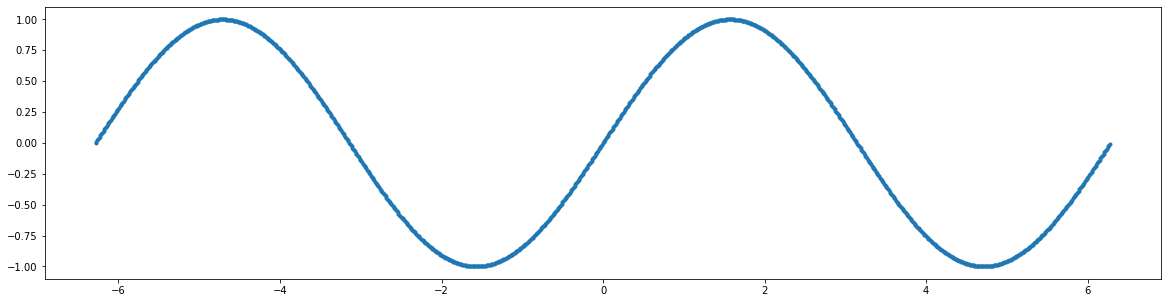

In [2]:
x = np.arange(-2 * np.pi, 2 * np.pi, 0.01)
y_true = np.sin(x)
plt.scatter(x, y_true, marker='.')

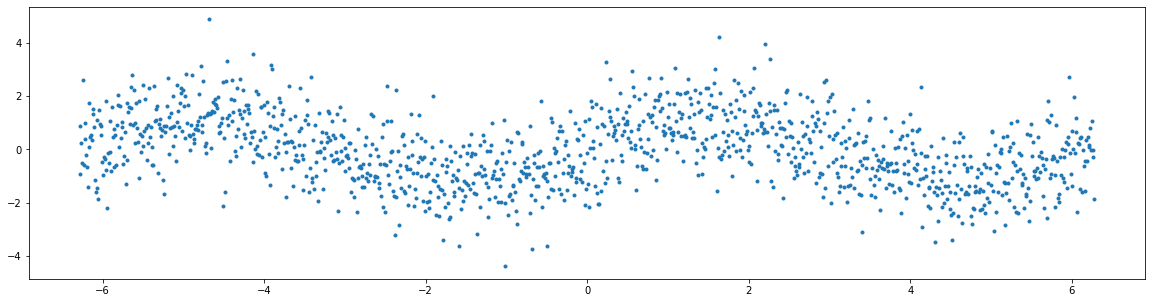

In [3]:
y = np.sin(x) + np.random.standard_normal(len(x))
plt.scatter(x, y, marker='.')
_, _, y_train_true, y_test_true = train_test_split(x, y_true, random_state=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1)

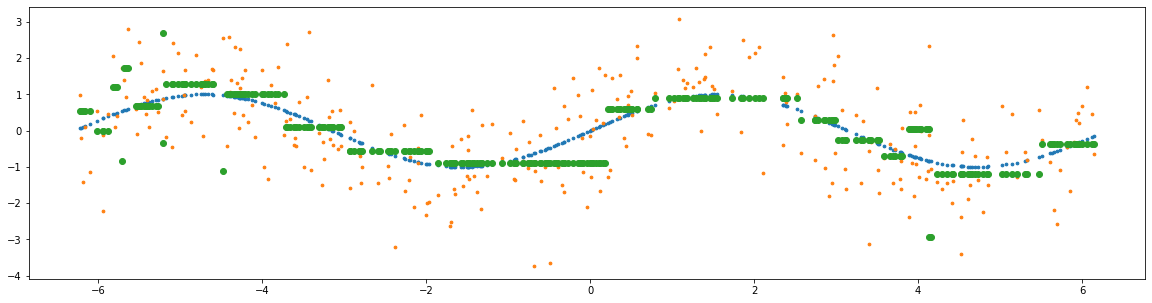

In [13]:
from sklearn.tree import DecisionTreeRegressor as dtr
regr = dtr(random_state=1, max_depth=5, min_samples_split=6).fit(x_train.reshape(-1, 1), y_train)
y_pred = regr.predict(x_test.reshape(-1, 1))

plt.scatter(x_test, y_test_true, marker='.',s=radius)
plt.scatter(x_test, y_test, marker='.',s=radius)
plt.scatter(x_test, y_pred, marker='o')
plt.show()

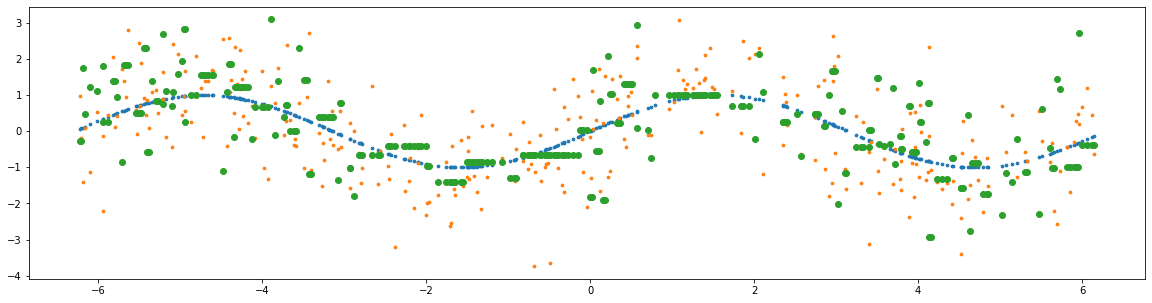

In [14]:
from sklearn.tree import DecisionTreeRegressor as dtr
regr = dtr(random_state=1, max_depth=10, min_samples_split=4).fit(x_train.reshape(-1, 1), y_train)
y_pred = regr.predict(x_test.reshape(-1, 1))

plt.scatter(x_test, y_test_true, marker='.',s=radius)
plt.scatter(x_test, y_test, marker='.',s=radius)
plt.scatter(x_test, y_pred, marker='o')
plt.show()

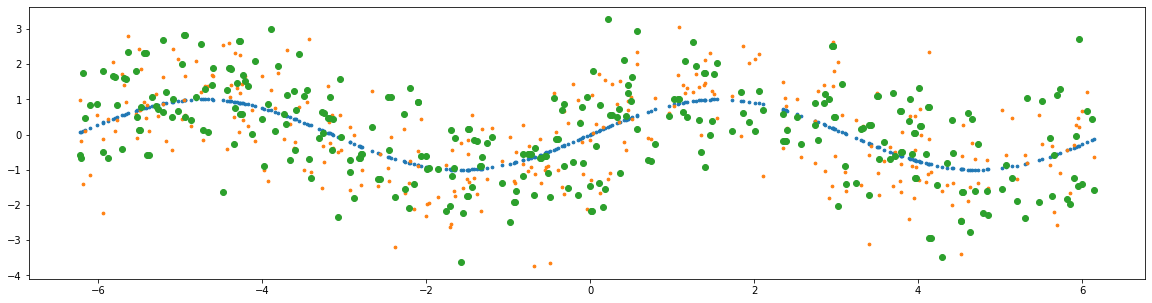

In [15]:
from sklearn.tree import DecisionTreeRegressor as dtr
regr = dtr(random_state=1, max_depth=20, min_samples_split=2).fit(x_train.reshape(-1, 1), y_train)
y_pred = regr.predict(x_test.reshape(-1, 1))

plt.scatter(x_test, y_test_true, marker='.',s=radius)
plt.scatter(x_test, y_test, marker='.',s=radius)
plt.scatter(x_test, y_pred, marker='o')
plt.show()

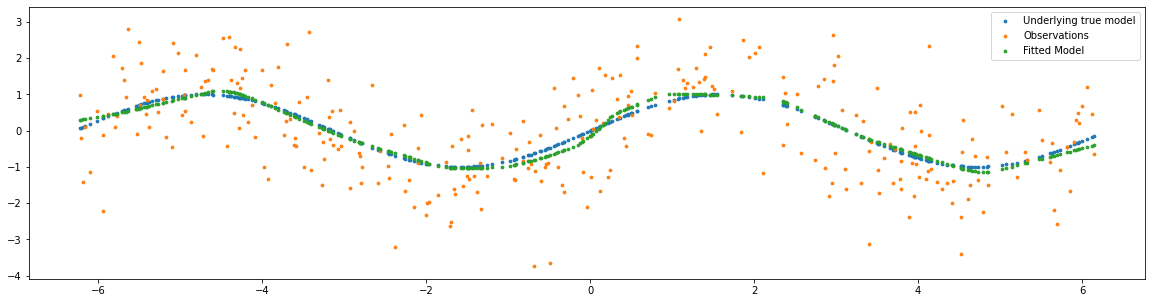

In [6]:
from sklearn.neural_network import MLPRegressor as mlp
regr = mlp(random_state=1, max_iter=500, hidden_layer_sizes=(100, 100, 100, 100, 100), alpha=0).fit(x_train.reshape(-1, 1), y_train)
y_pred = regr.predict(x_test.reshape(-1, 1))
plt.scatter(x_test, y_test_true, marker='.',s=radius, label='Underlying true model')
plt.scatter(x_test, y_test, marker='.',s=radius, label='Observations')
plt.scatter(x_test, y_pred, marker='.',s=radius, label='Fitted Model')
plt.legend()
plt.show()